In [1]:
### Data prep from DOH files ###
# For privacy reasons, raw files not provided.
import os
import pandas as pd
# Filepath
import pandas as pd
from os.path import isfile
from os.path import join
from os import listdir
filepath = 'PatientData'

# Get list of all files
files = os.listdir(filepath)

# Print the list of files
print(files)

# Create an empty list to store the dataframes
dataframes = []

# Loop through all files in the directory
for file in files:
    # Read the file
    print('Reading in:', filepath + '/' + file)
    df = pd.read_csv(filepath + '/' + file, low_memory=False, encoding='latin-1')
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate the list of dataframes
df = pd.concat(dataframes)

print(df.shape)
# Remove all rows where the Certification Status is not 'Active'
df = df[df['Certification Status'] == 'Active']
print(df.shape)

In [26]:
### Adding lat and long to each zipcode in the dispenary and patient data ###
import pandas as pd
import concurrent.futures

# Load the dispensary geo information
df_dispo = pd.read_csv('DispoZipLatLong.csv')

# Load the patient geo information
df_pat = pd.read_csv('PatientZipLatLong.csv')

# Make a list of all unique zipcodes
zipcodes_dispo = df_dispo['Zipcode'].unique()
zipcodes_pat = df_pat['Zipcode'].unique()

# Print the number of unique zipcodes
print('There are {} unique dispensary zipcodes.'.format(len(zipcodes_dispo)))
print('There are {} unique patient zipcodes.'.format(len(zipcodes_pat)))

# Count the number of times each zipcode appears in the dispenary and patient data
zipcode_counts_dispo = df_dispo['Zipcode'].value_counts()
zipcode_counts_pat = df_pat['Zipcode'].value_counts()

There are 135 unique dispensary zipcodes.
There are 1897 unique patient zipcodes.


In [27]:
# Combine the zipcode counts from dispensary and patient data into a single DataFrame
zipcode_counts_combined = pd.concat([zipcode_counts_dispo, zipcode_counts_pat], axis=1)
zipcode_counts_combined.columns = ['Dispensary Count', 'Patient Count']

# Fill missing values with 0 for zip codes that only appear in one dataset
zipcode_counts_combined.fillna(0, inplace=True)

# Reset the index to have zip codes as a column
zipcode_counts_combined.reset_index(inplace=True)
zipcode_counts_combined.columns = ['Zipcode', 'Dispensary Count', 'Patient Count']

# Remove any duplicates
zipcode_counts_combined.drop_duplicates(subset='Zipcode', inplace=True, ignore_index=True)

# Sort the DataFrame by zip codes
zipcode_counts_combined.sort_values('Zipcode', inplace=True, ignore_index=True)

In [30]:
# Read the zip code database CSV file
zip_code_db = pd.read_csv('zip_code_database.csv')

# Define the desired state
desired_state = 'PA'

# Filter the DataFrame to include only the zip codes of the desired state
filtered_zip_code_db = zip_code_db[zip_code_db['state'] == desired_state]

# Reset the index of the filtered DataFrame
filtered_zip_code_db.reset_index(drop=True, inplace=True)

# Function to get latitude and longitude for a given zip code
def get_lat_long(zipcode):
    row = filtered_zip_code_db[filtered_zip_code_db['zip'] == zipcode]
    if not row.empty:
        latitude = row['latitude'].values[0]
        longitude = row['longitude'].values[0]
        return latitude, longitude
    return None, None

# Iterate over each unique zip code in the DataFrame and fetch the coordinates using parallel processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Pull list of zip codes from the DataFrame
    zips = zipcode_counts_combined['Zipcode'].unique()
    results = executor.map(get_lat_long, zips)

    # Update the DataFrame with the latitude and longitude values
    for index, (zipcode, (latitude, longitude)) in zip(zipcode_counts_combined.index, zip(zipcode_counts_combined['Zipcode'], results)):
        if latitude is not None and longitude is not None:
            zipcode_counts_combined.at[index, 'Latitude'] = latitude
            zipcode_counts_combined.at[index, 'Longitude'] = longitude

# Save the DataFrame to a CSV file
zipcode_counts_combined.to_csv('Compiled_Data.csv', index=False)

In [93]:
from geopy.distance import geodesic
import numpy as np

# Load the compiled data
df = pd.read_csv('Compiled_Data.csv')

# Make a dataframe of dispensary locations where Dispensary Count > 0
# Make a deep copy of the dataframe
df_dispo = df[df['Dispensary Count'] > 0].copy()

# Make an iterable of tuples of dispensary coordinates
dispo_coords = list(zip(df_dispo['Latitude'], df_dispo['Longitude']))

# Make a dataframe of patients where Patient Count > 0
df_pat = df[df['Patient Count'] > 0].copy()

# Function to calculate distance using geopy
def calculate_distance(row):

    patient_coords = (row['Latitude'], row['Longitude'])
    # Make an empty list for distances
    distances = []

    # Map all dispos coords to patient coords to calculate distances
    for i in range(len(dispo_coords)):
        # Pick a dispo tuple
        current_dispo_coords = dispo_coords[i]

        # Calculate distance between patient and dispo coords, append to list
        distances.append(geodesic(patient_coords, current_dispo_coords).miles)

    # Find the index of the nearest dispo
    nearest_disp_distance = np.min(distances)

    # Find the index of the nearest dispo's row
    nearest_disp_index = np.argmin(distances, axis=0)

    # Find the zipcode of the nearest dispo in the dispo dataframe rows
    nearest_disp_zipcode = df_dispo.iloc[nearest_disp_index]['Zipcode']

    return nearest_disp_distance, nearest_disp_zipcode

# Make an empty column for nearest neighbor distances in df_pat
df_pat['Nearest Disp Distance'] = np.nan
df_pat['Nearest Disp Zipcode'] = np.nan

# Loop over each row in df_pat
for index, row in df_pat.iterrows():
    # Run process_patient on each row
    nearest_distance, nearest_zipcode = calculate_distance(row)

    # Update the nearest neighbor distance and zipcode in df_pat
    df_pat.loc[index, 'Nearest Disp Distance'] = nearest_distance
    df_pat.loc[index, 'Nearest Disp Zipcode'] = nearest_zipcode

# Combine df_dispo and df_pat into a single DataFrame df
df = pd.concat([df_dispo, df_pat], ignore_index=True)

# Fill empty values with NaN or empty string
df['Nearest Disp Distance'].fillna(value=pd.NA, inplace=True)
df['Nearest Disp Zipcode'].fillna(value='', inplace=True)

# Calculate patient-miles, or (distance to nearest dispo) * (patient count) for each row
df['Patient Miles'] = (df['Nearest Disp Distance'] * df['Patient Count'])
df['Patient Miles'].fillna(value=pd.NA, inplace=True)

# Save the combined DataFrame to a CSV file
df.to_csv('Distance Data.csv', index=False)

In [95]:
from geopy.distance import geodesic
import numpy as np

# Load the compiled data
df = pd.read_csv('Compiled_Data.csv')

# Make a dataframe of dispensary locations where Dispensary Count > 0
df_dispo = df[df['Dispensary Count'] > 0].copy()

# Make a dataframe of patients where Patient Count > 0
df_pat = df[df['Patient Count'] > 0].copy()

# Function to calculate distance using geopy
def calculate_distance(patient_coords):
    distances = []
    for dispo_coords in dispo_coords_list:
        distances.append(geodesic(patient_coords, dispo_coords).miles)
    nearest_disp_index = np.argmin(distances)
    nearest_disp_distance = distances[nearest_disp_index]
    nearest_disp_zipcode = df_dispo.iloc[nearest_disp_index]['Zipcode']
    return nearest_disp_distance, nearest_disp_zipcode

# Make an iterable of tuples of dispensary coordinates
dispo_coords_list = list(zip(df_dispo['Latitude'], df_dispo['Longitude']))

# Calculate nearest neighbor for each patient
nearest_distances = []
nearest_zipcodes = []
for row in df_pat.itertuples(index=False):
    if pd.notnull(row.Latitude) and pd.notnull(row.Longitude):
        patient_coords = (row.Latitude, row.Longitude)
        nearest_distance, nearest_zipcode = calculate_distance(patient_coords)
        nearest_distances.append(nearest_distance)
        nearest_zipcodes.append(nearest_zipcode)
    else:
        nearest_distances.append(np.nan)
        nearest_zipcodes.append('')

# Update the "Nearest Disp Distance" and "Nearest Disp Zipcode" columns in df_pat
df_pat['Nearest Disp Distance'] = nearest_distances
df_pat['Nearest Disp Zipcode'] = nearest_zipcodes

# Fill empty values with NaN or empty string
df_pat['Nearest Disp Distance'].fillna(value=pd.NA, inplace=True)
df_pat['Nearest Disp Zipcode'].fillna(value='', inplace=True)

# Calculate patient-miles
df_pat['Patient Miles'] = df_pat['Nearest Disp Distance'] * df_pat['Patient Count']
df_pat['Patient Miles'].fillna(value=pd.NA, inplace=True)

# Save the combined DataFrame to a CSV file
df_pat.to_csv('Distance Data.csv', index=False)

(array([667., 506., 332., 188.,  95.,  39.,  32.,  10.,   9.,  10.]),
 array([ 0.        ,  5.68484759, 11.36969519, 17.05454278, 22.73939037,
        28.42423796, 34.10908556, 39.79393315, 45.47878074, 51.16362834,
        56.84847593]),
 <BarContainer object of 10 artists>)

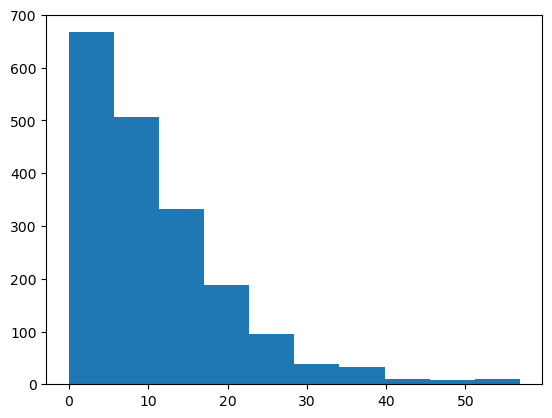

In [97]:
# Read in the data
import matplotlib.pyplot as plt
df = pd.read_csv('Distance Data.csv')
# Plot a histogram of the data
plt.hist(df['Nearest Disp Distance'])

In [5]:
import pandas as pd
import numpy as np
import concurrent.futures

# Read the zip code database CSV file
zip_code_db = pd.read_csv('zip_code_database.csv')

# read in dataset
df = pd.read_csv('Distance Data.csv')

# Define the desired state
desired_state = 'PA'

# Filter the DataFrame to include only the zip codes of the desired state
filtered_zip_code_db = zip_code_db[zip_code_db['state'] == desired_state]

# Reset the index of the filtered DataFrame
filtered_zip_code_db.reset_index(drop=True, inplace=True)

# Function to get county, population from zip code
def get_stats(zipcode):
    row = filtered_zip_code_db[filtered_zip_code_db['zip'] == zipcode]
    if not row.empty:
        pop = row['irs_estimated_population'].values[0]
        county = row['county'].values[0]
        return pop, county
    return None, None

# Iterate over each unique zip code in the DataFrame and fetch the coordinates using parallel processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Pull list of zip codes from the DataFrame
    zips = df['Zipcode'].unique()
    results = executor.map(get_stats, zips)

    # Update the DataFrame with the latitude and longitude values
    for index, (zipcode, (pop, county)) in zip(df.index, zip(df['Zipcode'], results)):
        if pop is not None and county is not None:
            df.at[index, 'Population'] = pop
            df.at[index, 'County'] = county

# Save the DataFrame to a CSV file
df.to_csv('Final_Data.csv', index=False)